In [2]:
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

2023-06-02 01:30:02.292555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 01:30:03.564947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0-py3-none-any.whl#egg=de_core_news_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/r

In [3]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [4]:
# define helper function

def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

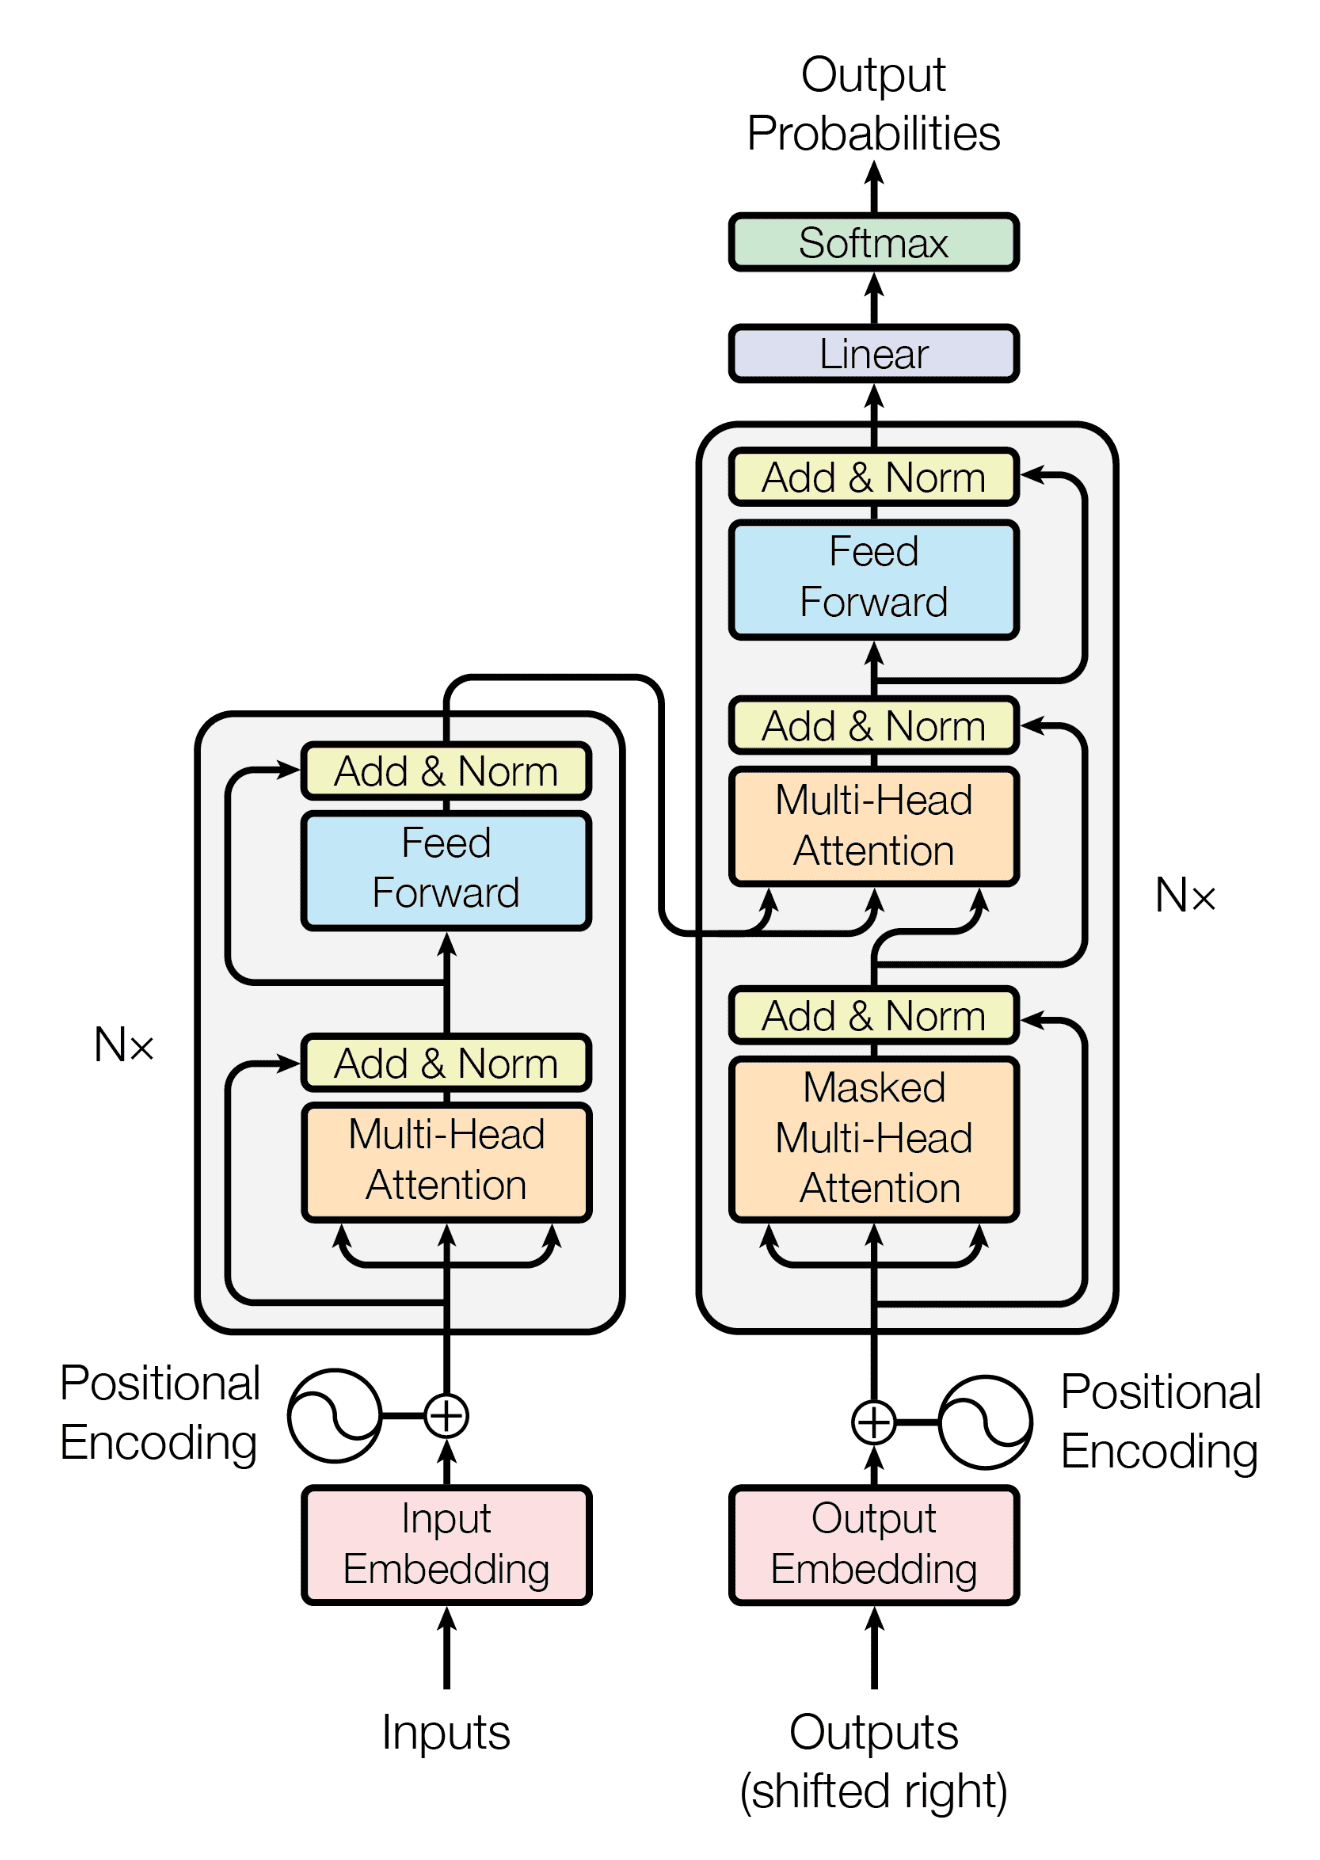

In [7]:
from PIL import Image
import requests

url = 'https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png'
image = Image.open(requests.get(url, stream=True).raw)
image

In [34]:
# generator

class Generator(nn.Module):
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return log_softmax(self.proj(x), dim=-1)

In [35]:
# encoder-decoder pipeline

class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

  def forward(self, src, tgt, src_mask, tgt_mask):
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [36]:
# clone encoder

def clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [37]:
# encoder

class Encoder(nn.Module):
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

In [38]:
# define layernorm  

class LayerNorm(nn.Module):
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (self.eps + std) + self.b_2

In [39]:
# define residual-connection and layernorm

class SublayerConnection(nn.Module):
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

In [40]:
# encoder layer

class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

In [41]:
# decoder

class Decoder(nn.Module):
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In [42]:
# decoder layer

class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

In [43]:
# define mask

def subsequent_mask(size):
  attn_shape = (1, size, size)
  subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
  return subsequent_mask == 0

In [44]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

In [45]:
# define attention

def attention(query, key, value, mask=None, dropout=None):
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = scores.softmax(dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

In [46]:
# define multi-head attention

class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)

    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for lin, x in zip(self.linears, (query, key, value))
    ]

    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    x = (x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k))
    del query
    del key
    del value
    return self.linears[-1](x)

In [47]:
# define point-wise feed-forward

class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

In [48]:
# define embeddings

class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model
  
  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

In [49]:
# define positional encoding

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)
  
  def forward(self, x):
    x = x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout(x)

In [50]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

In [51]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  return model

In [52]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 9, 9, 9, 9, 9, 9, 9, 9, 4]])
Example Untrained Model Prediction: tensor([[0, 3, 2, 3, 2, 3, 2, 3, 2, 3]])
Example Untrained Model Prediction: tensor([[0, 5, 0, 5, 0, 5, 5, 5, 5, 0]])
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 6, 2, 1, 6, 4, 6, 2, 8, 6]])
Example Untrained Model Prediction: tensor([[0, 1, 7, 9, 9, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 6, 1, 9, 6, 6, 1, 6, 1, 6]])
Example Untrained Model Prediction: tensor([[0, 1, 7, 2, 8, 7, 2, 8, 7, 2]])
Example Untrained Model Prediction: tensor([[ 0,  2,  9,  2, 10,  6,  2,  9,  1,  9]])
Example Untrained Model Prediction: tensor([[0, 6, 4, 6, 8, 7, 2, 0, 6, 4]])
